In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path

from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [2]:
conf = yaml.safe_load(Path('config.yml').read_text())['reachability']

In [3]:
geometric_graph_conf = conf['random_geometric']

In [4]:
results_dict_list = []
modality = "reversable"
for graph_rad in geometric_graph_conf['graph_edge_radii']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph radius {graph_rad}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=geometric_graph_conf['structure_name'], 
            num_nodes=int(geometric_graph_conf['nodes']), 
            graph_edge_radius = float(graph_rad)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

simulation run for graph radius 0.025


20it [00:01, 16.46it/s]


simulation run for graph radius 0.05


20it [01:02,  3.14s/it]


In [5]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = padded_list
            #result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

100%|██████████| 2/2 [00:00<00:00, 226.95it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


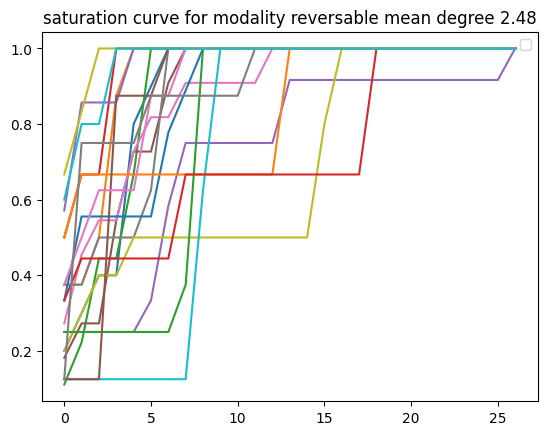

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


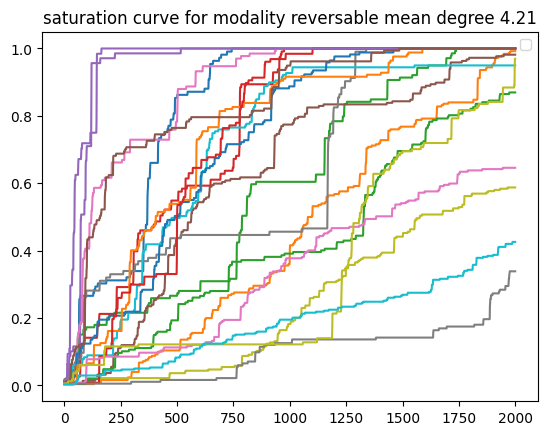

In [9]:
for i, result in enumerate(results_dict_list): 
        for iter in result['fraction_infected_list']:
            timesteps_list = [x for x in range(len(iter))]
            try:
                p, cov = curve_fit(logistic, timesteps_list, iter)
                logistic_curve_data = logistic(timesteps_list, *p)
            except:
                pass
            plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
        #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
        plt.title(f"saturation curve for modality {result['info_dict']['modality']} mean degree {round(result['info_dict']['average_degree'], 2)}")
        plt.legend()
        plt.show()

In [ ]:
w4t

In [ ]:
results_dict_list = []
modality = "irreversable"
for graph_rad in geometric_graph_conf['graph_edge_radii']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph radius {graph_rad}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=geometric_graph_conf['structure_name'], 
            num_nodes=int(geometric_graph_conf['nodes']), 
            graph_edge_radius = float(graph_rad)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for result in results_dict_list: 
    timesteps_list = [x for x in range(len(result['fraction_infected_list']))]

    p, cov = curve_fit(logistic, timesteps_list, result['fraction_infected_list'])
    logistic_curve_data = logistic(timesteps_list, *p)
    print("run statistics")
    print(result['info_dict'])
    plt.plot(timesteps_list, result['fraction_infected_list'], label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for modality {result['info_dict']['modality']} mean degree {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
albert_graph_config = conf['barabasi_albert']
albert_graph_config

In [ ]:
results_dict_list = []
modality = "reversable"
for node_degree in albert_graph_config['node_degree']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph degree {node_degree}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=albert_graph_config['structure_name'], 
            num_nodes=int(albert_graph_config['nodes']), 
            node_degree = int(node_degree)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for result in results_dict_list: 
    timesteps_list = [x for x in range(len(result['fraction_infected_list']))]

    p, cov = curve_fit(logistic, timesteps_list, result['fraction_infected_list'])
    logistic_curve_data = logistic(timesteps_list, *p)
    print("run statistics")
    print(result['info_dict'])
    plt.plot(timesteps_list, result['fraction_infected_list'], label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for modality {result['info_dict']['modality']} mean degree {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
results_dict_list = []
modality = "irreversable"
for node_degree in albert_graph_config['node_degree']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph degree {node_degree}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=albert_graph_config['structure_name'], 
            num_nodes=int(albert_graph_config['nodes']), 
            node_degree = int(node_degree)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for result in results_dict_list: 
    timesteps_list = [x for x in range(len(result['fraction_infected_list']))]

    p, cov = curve_fit(logistic, timesteps_list, result['fraction_infected_list'])
    logistic_curve_data = logistic(timesteps_list, *p)
    print("run statistics")
    print(result['info_dict'])
    plt.plot(timesteps_list, result['fraction_infected_list'], label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for modality {result['info_dict']['modality']} mean degree {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
try: 
            #Fit a logistic curve to the simulated infection data for one simulation run, generate data with this logistic, use to find residuals in fit
            p, cov = curve_fit(logistic, timesteps, fraction_infected_list)
            logistic_curve_data = logistic(timesteps, *p)
            residuals_dict[graph_rad].extend(fraction_infected_list - logistic_curve_data)
            mean_degree_simulation_runs.append(average_degree)
        except RuntimeError as e:
            print(e)
            pass 
    average_degrees.append(np.mean(mean_degree_simulation_runs))

#Update keys of dictionary so that keys are the (averaged) mean degree of the simulations networks
residuals_dict = {k : v for k,v in list(zip(average_degrees, residuals_dict.values()))}
least_noisy_data = residuals_dict
for key in residuals_dict.keys(): 
    sns.kdeplot(residuals_dict[key], label=f"mean degree : {round(key, 2)}")
plt.legend()
plt.show()